# Exercício Prático 2: Triangulação de Polígono

Implemente um algoritmo de triangulação de polígono. Se tiver acesso a uma interface gráfica, acrescente no relatório screenshots dos resultados obtidos. Se não tiver acesso a uma interface gráfica, seu algoritmo pode ter como saída uma lista de triângulos. Você pode considerar como entrada uma lista de vértices no sentido anti-horário.

## Parametros do trabalho

In [10]:
TOLERANCIA = 1e-10
NUMERO_MAXIMO_ITERACOES = 1000

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional


@dataclass
class Aresta:
    p1: np.ndarray
    p2: np.ndarray

    def __and__(self, other:'Aresta') -> bool:

        """Detecta se as arestas se cruzam"""
        # detminante da matriz dos coeficientes (com a primeira coluna sendo 1s) e cada linha sendo um ponto
        uns = np.ones((3,1))
        matriz_1 = np.hstack((uns, np.array([self.p1, self.p2, other.p1])))
        matriz_2 = np.hstack((uns, np.array([self.p1, self.p2, other.p2])))
        matriz_3 = np.hstack((uns, np.array([other.p1, other.p2, self.p1])))
        matriz_4 = np.hstack((uns, np.array([other.p1, other.p2, self.p2])))
        det_1 = la.det(matriz_1)
        det_2 = la.det(matriz_2)
        det_3 = la.det(matriz_3)
        det_4 = la.det(matriz_4)
        
        return (det_1 * det_2 < 0) and (det_3 * det_4 < 0)



@dataclass
class Poligono:
    arestas: list[Aresta]
    pontos: list[np.ndarray] = field(init=False)

    def __post_init__(self):
        # pontos em ordem, a1.p1, a1.p2, a2.p1, a2.p2, ...
        self.pontos = []
        for aresta in self.arestas:
            self.pontos.append(aresta.p1)
            self.pontos.append(aresta.p2)


    @staticmethod
    def gera_poligono_aleatorio(numero_de_lados:int, intervalo = (-100, 100)) -> 'Poligono':
        """Gera um polígono aleatório com o número de lados especificado e ordenado no sentido anti-horário"""
        x_ordenado = np.sort(np.random.uniform(intervalo[0], intervalo[1], numero_de_lados))

        meio = 0.5* sum(intervalo)

        pontos_superiores = x_ordenado[::2]
        pontos_inferiores = x_ordenado[1::2][::-1]

        y_superior = np.random.uniform(meio, intervalo[1], len(pontos_superiores))
        y_inferior = np.random.uniform(intervalo[0], meio, len(pontos_inferiores))

        # Criamos os pontos
        pontos = np.vstack((np.column_stack((pontos_superiores, y_superior)), np.column_stack((pontos_inferiores, y_inferior))))
        # mudamos o centro de lugar ao adicionar um vetor aleatório
        pontos += np.random.uniform(intervalo[0]/2, intervalo[1]/2, (1,2))
        # Criamos as arestas
        arestas = [Aresta(pontos[i], pontos[(i+1) % numero_de_lados]) for i in range(numero_de_lados)]
        return Poligono(arestas)

    def plot_poligono(self):
        """Plota o polígono"""
        for aresta in self.arestas:
            plt.plot([aresta.p1[0], aresta.p2[0]], [aresta.p1[1], aresta.p2[1]], 'b-')
        plt.fill([aresta.p1[0] for aresta in self.arestas], [aresta.p1[1] for aresta in self.arestas], 'b', alpha=0.3)
        plt.axis('equal')
        plt.show()

    def plot_triangulacao(self, triangulos: list[tuple[np.ndarray, np.ndarray, np.ndarray]]):
        """Plota o polígono e a triangulação"""
        for triangulo in triangulos:
            pts = np.array(triangulo + (triangulo[0],))  # fecha o triângulo
            plt.plot(pts[:,0], pts[:,1], 'r-')
        plt.axis('equal')
        self.plot_poligono()


    def ponto_mais_a_esquerda(self) -> np.ndarray:
        """Retorna o ponto mais a esquerda do polígono"""
        return min((aresta.p1 for aresta in self.arestas), key=lambda p: p[0])


    def __contains__(self, ponto: np.ndarray) -> bool:
        """Usando raycasting para detectar se o ponto está dentro do polígono"""
        # Criamos uma aresta que vai do ponto para a direita
        ponto_extremo = self.ponto_mais_a_esquerda() + np.array([-1, 0])
        aresta_teste = Aresta(ponto, ponto_extremo)
        numero_de_intersecoes = sum(1 for aresta in self.arestas if aresta & aresta_teste)
        return numero_de_intersecoes % 2 == 1    

    def eh_orelha(self, ponto1: np.ndarray, ponto3: np.ndarray) -> bool:
        """Verifica se o triângulo formado pelos três pontos é uma orelha do polígono"""
        ponto_medio = (ponto1 + ponto3) / 2
        return ponto_medio in self

    def triangularinator(self, poligono_atual: 'Poligono') -> list[tuple[np.ndarray, np.ndarray, np.ndarray]]:
        """Triangulariza o polígono usando o algoritmo de ear clipping"""
        if len(poligono_atual.arestas) == 3:
            return [(poligono_atual.arestas[0].p1, poligono_atual.arestas[0].p2, poligono_atual.arestas[1].p2)]
        
        for i in range(len(poligono_atual.arestas)-1):
            aresta_atual = poligono_atual.arestas[i]
            aresta_anterior = poligono_atual.arestas[i - 1]
            aresta_proxima = poligono_atual.arestas[i + 1]

            if self.eh_orelha(aresta_anterior.p1, aresta_proxima.p2):
                novo_poligono_arestas = poligono_atual.arestas[:i] + poligono_atual.arestas[i+1:]
                novo_poligono_arestas[i - 1] = Aresta(aresta_anterior.p1, aresta_proxima.p2)
                novo_poligono = Poligono(novo_poligono_arestas)
                novo_poligono.plot_poligono()
                return [(aresta_anterior.p1, aresta_atual.p1, aresta_proxima.p2)] + self.triangularinator(novo_poligono)

        raise ValueError("Não foi possível encontrar uma orelha para cortar. O polígono pode ser inválido.")


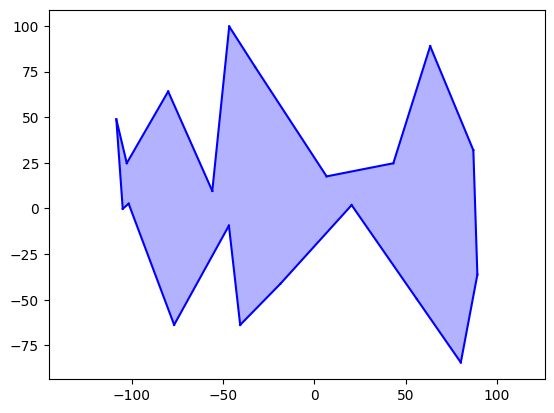

In [12]:
poly = Poligono.gera_poligono_aleatorio(20)
poly.plot_poligono()

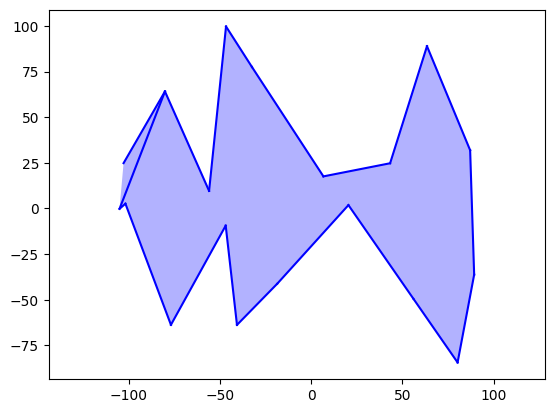

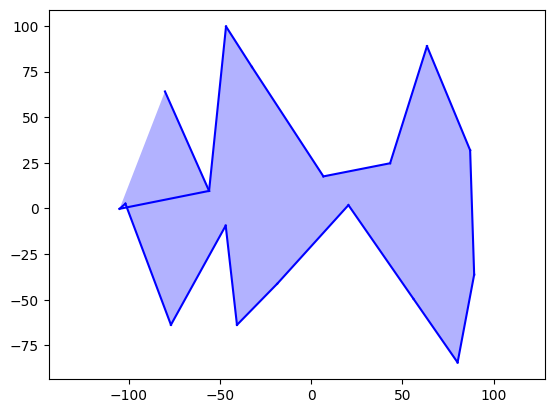

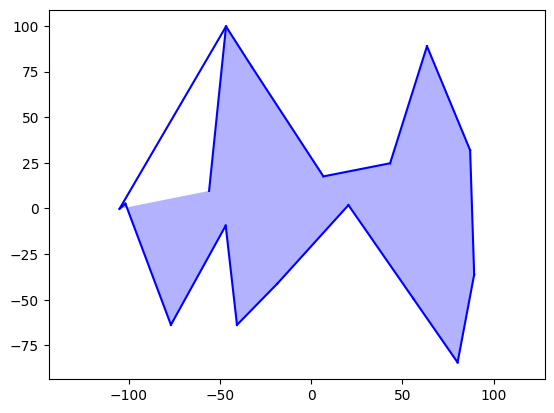

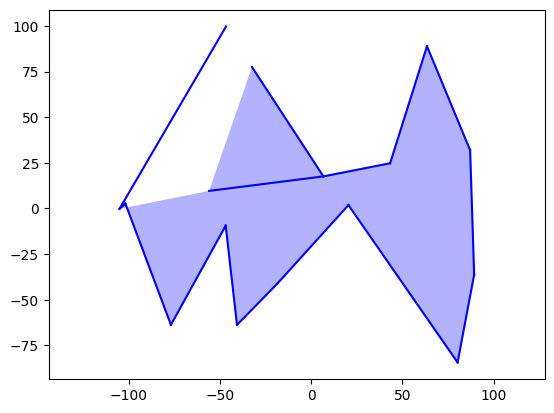

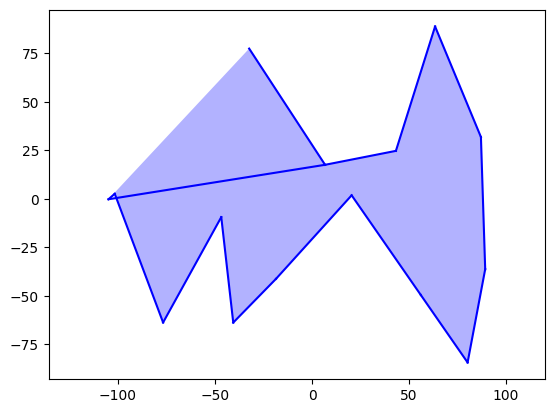

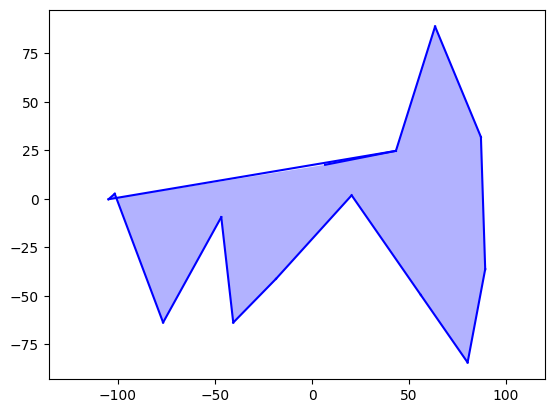

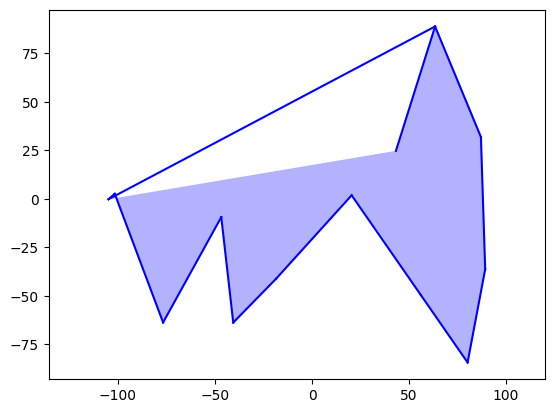

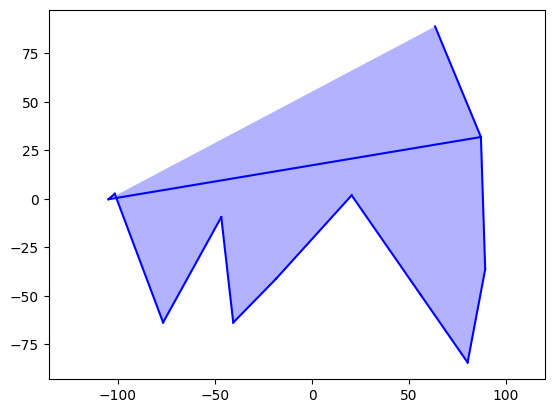

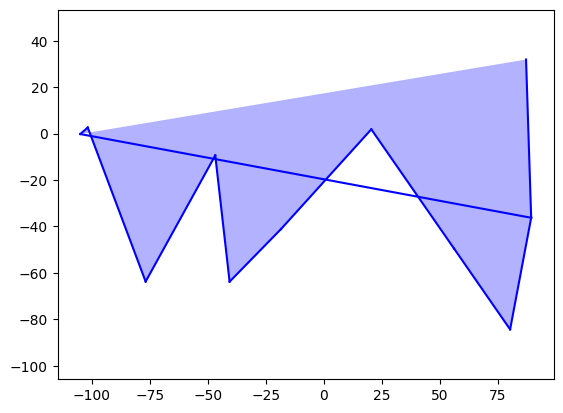

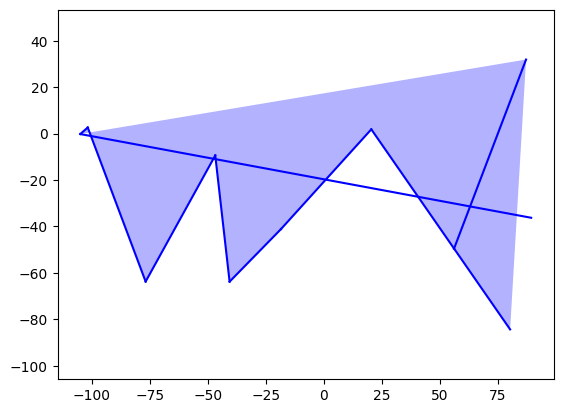

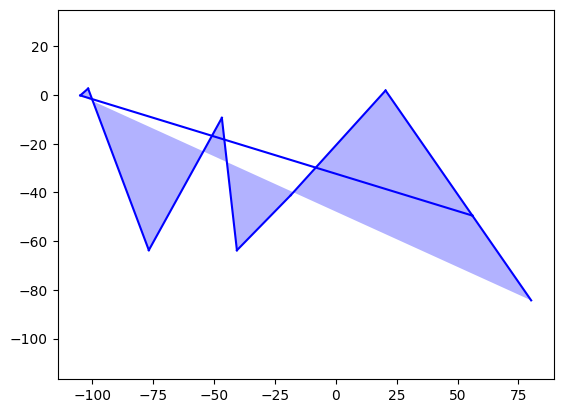

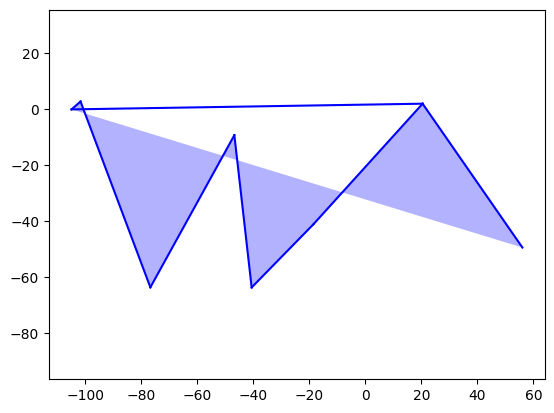

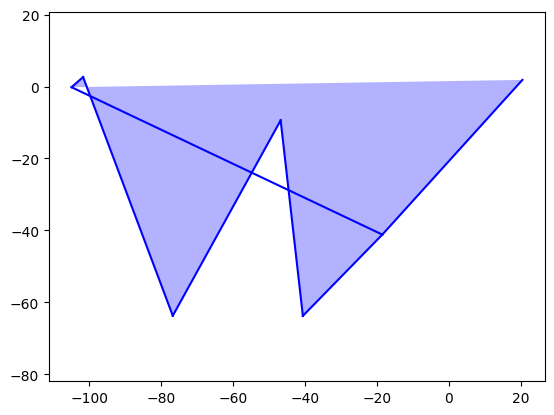

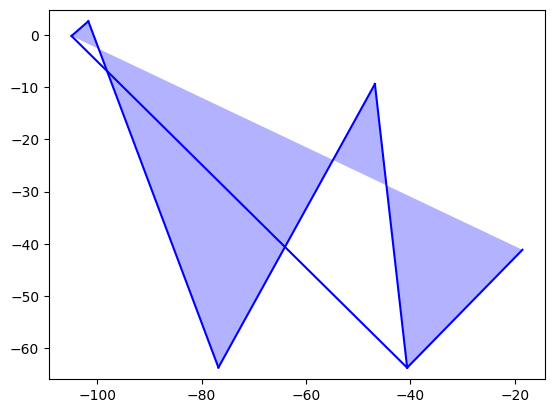

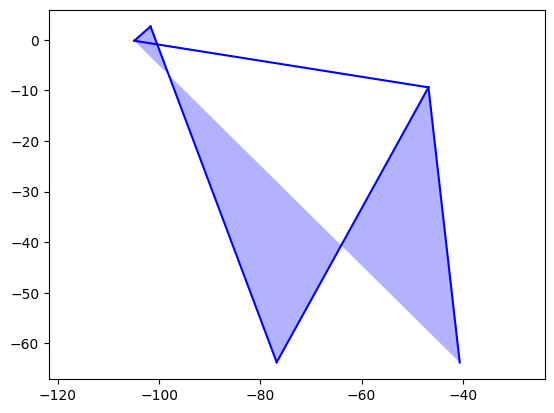

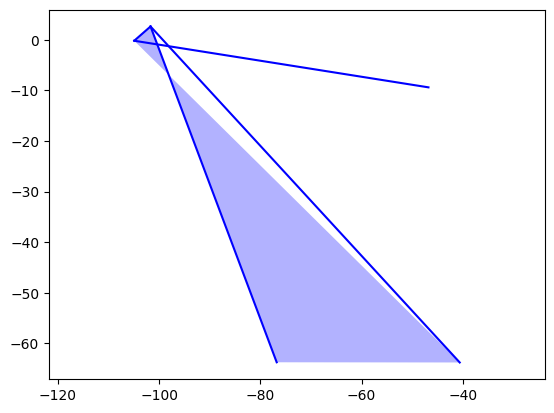

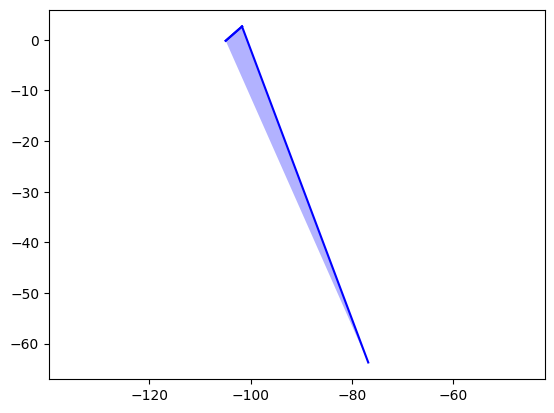

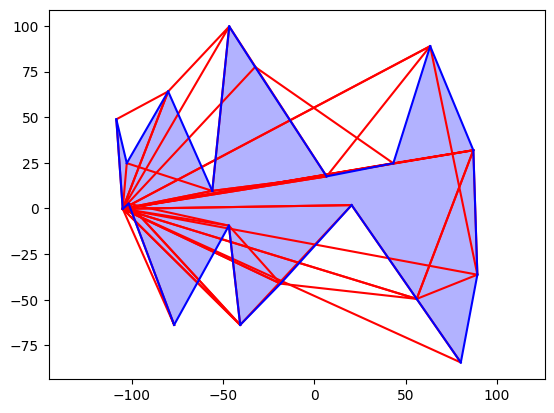

In [13]:
triangulos = poly.triangularinator(poly)
poly.plot_triangulacao(triangulos)